In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
_data = pd.read_csv('../resources/data.csv', skiprows=[2])

In [3]:
ans_key = _data.head(1)

In [4]:
data = _data.drop(_data.index[0])

## Adding more columns
* Test grade
* Answered questions

In [5]:
data["TestGrade"]=[None]*data.shape[0]
data["QuestionsAnswered"]=[None]*data.shape[0]
data["PostGrade"]=[None]*data.shape[0]
data["PostAnswers"]=[None]*data.shape[0]

In [6]:
#data.iloc[0] # Check to see if it work

In [7]:
#for index, row in data.iterrows(): print(index)

In [8]:
#for x in range(27): print(data.iloc[0][x+5] == ans_key.iloc[0][x])

In [9]:
post_grades = {}
for index, row in data.iterrows():
    grade = 0
    answered = 0
    for x in range(27):
        if(not row.isna()[x+5]):
            answered += 1
            if(row[x+5] == ans_key.iloc[0][x]):
                grade += 1
    data.loc[index,"QuestionsAnswered"] = answered
    data.loc[index,"TestGrade"] = grade / 27.0
    if (row[2] == "Post"):
        post = {}
        post[row[1]] = [row[3], data.loc[index,"TestGrade"], data.loc[index,"QuestionsAnswered"]]
        post_grades[row[0]] = post
for a in post_grades:
    for b in post_grades[a]:
        grade = post_grades[a][b][1]
        answers = post_grades[a][b][2]
        data.loc[(data['Participant Code'] == a) & (data['Test'] == 'Pre') & (data['Term'] == b),'PostGrade'] = grade
        data.loc[(data['Participant Code'] == a) & (data['Test'] == 'Pre') & (data['Term'] == b), 'PostAnswers'] = answers

In [10]:
data.shape

(147, 37)

In [11]:
preScores = data[data['PostGrade'].notnull()]

In [12]:
preScores.head()

,Participant Code,Term,Test,Instructor,LetterGrade,PercentGrade,Q1,Q2,Q3,Q4,...,Q22,Q23,Q24,Q25,Q26,Q27,TestGrade,QuestionsAnswered,PostGrade,PostAnswers
3,82,1.0,Pre,A,B+,84.94,C,C,A,C,...,D,C,A,E,B,B,0,26,0.148148,25
6,76,1.0,Pre,A,A,95.57,A,NaN,D,NaN,...,NaN,C,NaN,NaN,NaN,NaN,0.037037,9,0.185185,21
8,75,1.0,Pre,A,A,99.57,A,NaN,D,A,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0740741,16,0.185185,23
11,70,1.0,Pre,A,A,98.74,B,NaN,D,B,...,NaN,C,NaN,NaN,NaN,NaN,0.0740741,18,0.148148,25
15,84,1.0,Pre,A,A,94.17,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0.148148,27


In [13]:
isolatedInfo = preScores[['Participant Code', 'Term', 'Instructor', 'LetterGrade', 'PercentGrade', 'TestGrade', 'PostGrade', 'QuestionsAnswered', 'PostAnswers']]

In [14]:
isolatedInfo = isolatedInfo.copy()

In [15]:
isolatedInfo[isolatedInfo["QuestionsAnswered"] > isolatedInfo["PostAnswers"]]

,Participant Code,Term,Instructor,LetterGrade,PercentGrade,TestGrade,PostGrade,QuestionsAnswered,PostAnswers
3,82,1.0,A,B+,84.94,0,0.148148,26,25
18,9,1.0,A,A,95.77,0.0740741,0.111111,26,23
38,46,1.0,A,B-,73.01,0.111111,0.222222,27,25
41,78,1.0,A,C,66.93,0.111111,0.185185,27,26
73,3,1.0,B,F,28.76,0.0740741,0,8,1
75,81,1.0,B,A,93.88,0.185185,0,27,1
78,64,1.0,B,A,101.30,0.259259,0.0740741,26,20
116,41,2.0,B,C,73.58,0.0740741,0.037037,17,13
133,1,2.0,B,A,97.72,0.148148,0.037037,25,12


# Hypothesis
On average, those that scored higher in the class should be able to answer more questions and have a higher grade.
## Test
To test this hypothesis, I'll pull the test grades for all students that have a post-grade. I'll create the following graphs:
* Students by letter grade - Improvement in answers (post answers - pre answers)
* Students by letter grade - Improvement in percentages (post grade - pre grade)
* Improvement in answers (post grade - pre grade) - improvement in answers (post answers - pre answers)

In [16]:
isolatedInfo["gradeImprovement"]=[None]*isolatedInfo.shape[0]
isolatedInfo["answersImprovement"]=[None]*isolatedInfo.shape[0]
isolatedInfo["gradeValue"]=[None]*isolatedInfo.shape[0]

In [17]:
def getAvgsDict(x, y):
    avgs = {}
    totals = {}
    for i in range(len(x)):
        avgs[x[i]] += y[i]
        totals[x[i]] += 1
    for n in avgs:
        avgs[n] /= totals[n]
    return avgs

def getAvgsArr(x, y):
    avgs = {}
    totals = {}
    for i in range(len(x)):
        if x[i] not in avgs:
            avgs[x[i]] = 0
        avgs[x[i]] += y[i]
        if x[i] not in totals:
            totals[x[i]] = 0
        totals[x[i]] += 1
    for n in avgs:
        avgs[n] /= totals[n]
    retX = []
    retY = []
    retSize = []
    for n in avgs:
        retX.append(n)
        retY.append(avgs[n])
        retSize.append(totals[n])
    return retX, retY, retSize

def getApproximateTendline(x, y):
    x, y, s = getAvgsArr(x, y)
    retX = []
    retY = []
    pushDir = 0
    Smax = max(s)
    centerX = x[0]
    centerY = y[0]
    for n in range(len(s)):
        if s[n] == Smax:
            centerX = x[n]
            centerY = y[n]
            break
    for n in range(len(x)):
        r = abs(x[n] - centerX)
        f = (y[n] - centerY)
        pushDir += f*r
    pushDir /= len(x)*Smax
    # y = mx + b
    # m = pushDir
    # b = centerY - ((centerX-x[0]) * pushDir)
    x_ = [min(x), max(x)]
    retX = [x_[0], x_[1]]
    retY = [centerY - ((centerX-x_[0])*pushDir), centerY + ((x_[1] - centerX)*pushDir)]
    return retX, retY

In [18]:
def drawGraph(x_axis, y_axis, labels):
    draw = isolatedInfo.sort_values(by=[x_axis])
    x = draw[[x_axis]].to_numpy().flatten()
    y = draw[[y_axis]].to_numpy().flatten()
    plt.plot(x, y, 'o')

    # "Trendline"
    x_, y_ = getApproximateTendline(x, y)
    plt.plot(x_, y_, "r--")
    
    plt.title(labels[0])
    plt.ylabel(labels[1])
    plt.xlabel(labels[2])

    if len(x_ticks) > 0:
        plt.xticks(np.arange(len(x_ticks)),x_ticks)
    plt.show()

In [19]:
grade_dict = {}
x_ticks = []
i = 0
for a in ["A", "B", "C", "D", "F"]:
    for b in ["+", "", "-"]:
        grade_dict[(a+b)] = i
        i += 1
        x_ticks.append(a+b)

In [20]:
for index, row in isolatedInfo.iterrows():
    grade = row["PostGrade"] - row["TestGrade"]
    answers = row["PostAnswers"] - row["QuestionsAnswered"]
    isolatedInfo.loc[index,"gradeImprovement"] = grade
    isolatedInfo.loc[index,"answersImprovement"] = answers
    isolatedInfo.loc[index,"gradeValue"] = grade_dict[row["LetterGrade"]]

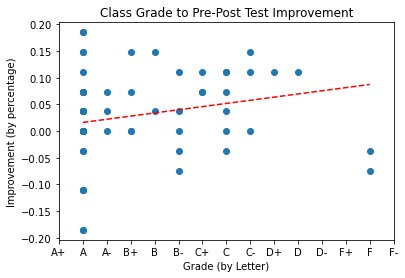

In [21]:
drawGraph("gradeValue", "gradeImprovement",
          ["Class Grade to Pre-Post Test Improvement", "Improvement (by percentage)", "Grade (by Letter)"])

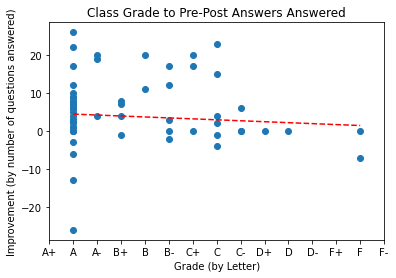

In [22]:
drawGraph("gradeValue", "answersImprovement",
          ["Class Grade to Pre-Post Answers Answered", "Improvement (by number of questions answered)", "Grade (by Letter)"])

In [23]:
x_ticks = []

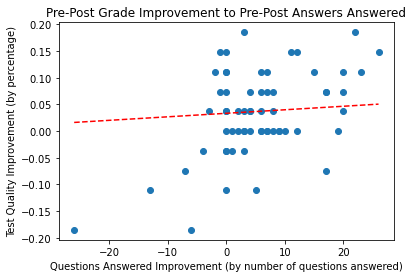

In [24]:
drawGraph("answersImprovement", "gradeImprovement",
          ["Pre-Post Grade Improvement to Pre-Post Answers Answered", "Test Quality Improvement (by percentage)", "Questions Answered Improvement (by number of questions answered)"])

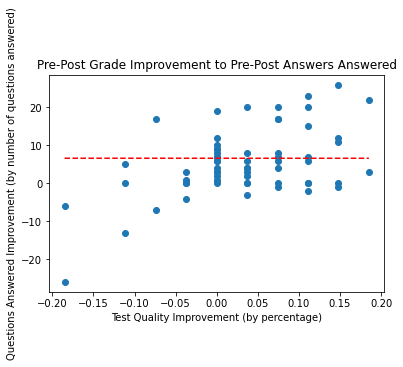

In [25]:
drawGraph("gradeImprovement", "answersImprovement",
          ["Pre-Post Grade Improvement to Pre-Post Answers Answered", "Questions Answered Improvement (by number of questions answered)", "Test Quality Improvement (by percentage)"])

# Analysis

## Results
